In [1]:
import os

os.makedirs("/kaggle/working/dl", exist_ok = True)

for fname in [
    "VinaFood.py",
    "Resnet_Blocks.py",
    "ResNet.py",
    "main_resnet.py"
]:
  open(f"/kaggle/working/dl/{fname}", "w").close()

## Câu 3: ResNet

In [2]:
%%writefile /kaggle/working/dl/VinaFood.py
import torch
from torch.utils.data import Dataset
from pathlib import Path # xử lý đường dẫn
from PIL import Image # đọc ảnh
import os

def collate_fn(samples: list[dict]) -> torch.Tensor:
  images = [sample["image"] for sample in samples]
  labels = [sample["label"] for sample in samples]

  images = torch.cat(images, dim = 0) # Ghép các tensor [1, 3, H, W] lại thành [bs, 3, H, W]
  labels = torch.tensor(labels) # Chuyển list các label (số) [0, 1, 2, 0] thành tensor [bs]

  return {
      "image": images,
      "label": labels
  }

class VinaFood(Dataset):
  def __init__(self, image_path: str, transform = None):
    super().__init__()

    self.root_dir = Path(image_path)
    self.transform = transform

    # 1. Lấy danh sách tên thư mục con
    # Sắp xếp thứ tự
    self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])

    # 2. Tạo map từ labels sang số
    self.class_to_idx = {
        cls_name: i for i, cls_name in enumerate(self.classes)
    }

    # 3. Quét toàn bộ thư mục để lấy đường dẫn ảnh và nhãn tương ứng
    self.samples = []

    for class_name in self.classes:
      class_idx = self.class_to_idx[class_name] # lấy số
      class_dir = self.root_dir / class_name

      # Lặp qua các file trong thư mục clas đó
      for img_path in class_dir.iterdir():
        self.samples.append((img_path,class_idx))

  def __len__(self) -> int:
    return len(self.samples)

  def __getitem__(self, idx) -> dict:
    # Lấy đường dẫn và nhãn qua index
    img_path, label = self.samples[idx]

    # Đọc ảnh
    image = Image.open(img_path).convert("RGB")

    # Áp dụng transform nếu có
    if self.transform:
      image = self.transform(image)

    if isinstance(image, torch.Tensor):
      image = image.unsqueeze(0)

    return {
        "image": image,
        "label": label
    }

Overwriting /kaggle/working/dl/VinaFood.py


In [3]:
%%writefile /kaggle/working/dl/Resnet_Blocks.py
import torch
from torch import nn

class Resnet_Blocks(nn.Module):
  expansion = 1 

  def __init__(self, in_channels, out_channels, stride = 1):
    super().__init__()
    # Nhánh chính
    ## Lớp conv 3x3
    self.conv1 = nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = (3,3),
        stride = stride,
        padding = 1
    )
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace = True)

    # Lớp 3x3 thứ hai
    self.conv2 = nn.Conv2d(
        out_channels,
        out_channels,
        kernel_size = (3,3),
        stride = 1,
        padding = 1
    )
    self.bn2 = nn.BatchNorm2d(out_channels)


    # Nhánh phụ
    self.shortcut = nn.Sequential() # Măc định không làm gì

    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(
              in_channels,
              out_channels,
              kernel_size = (1,1),
              stride = stride
          ),
          nn.BatchNorm2d(out_channels)
      )

  def forward(self,x):
    # Lưu lại đầu vào cho short cut
    identity = x

    # Nhánh chính
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    # Cộng với nhánh shortcut
    out += self.shortcut(identity)

    # Áp dụng ReLu
    out = self.relu(out)
    return out

Overwriting /kaggle/working/dl/Resnet_Blocks.py


In [4]:
%%writefile /kaggle/working/dl/ResNet.py
import torch
from torch import nn
from Resnet_Blocks import Resnet_Blocks

class ResNet(nn.Module):
  def __init__(self, num_labels):
    super().__init__()

    self.in_channels = 64

    # Phần đầu
    # 7x7 conv
    self.conv1 = nn.Conv2d(
        in_channels =3,
        out_channels = 64,
        kernel_size = (7,7),
        stride = 2,
        padding = 3
    )

    # Batch norm
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace = True)
    self.maxpool = nn.MaxPool2d(kernel_size = (3,3),stride = 2, padding = 1)

    self.layer1 = self.make_layer(
        block=Resnet_Blocks,
        out_channels=64,
        num_blocks=2,
        stride=1
    )

    self.layer2 = self.make_layer(
        block=Resnet_Blocks,
        out_channels=128,
        num_blocks=3,
        stride=2
    )

    self.layer3 = self.make_layer(
        block=Resnet_Blocks,
        out_channels=64,
        num_blocks=3,
        stride=1
    )

    # Global AvePool
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    # FC
    self.fc = nn.Linear(64*Resnet_Blocks.expansion, num_labels)

  def make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks - 1)
    layers = []
    for s in strides:
      layers.append(block(self.in_channels, out_channels,s))


      self.in_channels = out_channels * block.expansion

    return nn.Sequential(*layers)

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)

    return x

Overwriting /kaggle/working/dl/ResNet.py


## Main

In [ ]:
%%writefile /kaggle/working/dl/main_resnet.py
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import numpy as np
import os
import torchvision.transforms as transforms # Cần cho VinaFood
from VinaFood import collate_fn as vinafood_collate_fn, VinaFood
from ResNet import ResNet
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = "/kaggle/working/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- Các hàm helper ---
def evaluate(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> dict:
    model.eval()
    predicts = []
    labels_list = []
    losses = []

    with torch.no_grad():
        for item in dataloader:
            image = item["image"].to(device)
            label = item["label"].to(device)
            output = model(image)

            loss = loss_fn(output, label) 
            losses.append(loss.item())
            output = output.argmax(dim=-1)

            predicts.extend(output.cpu().numpy())
            labels_list.extend(label.cpu().numpy())

    return {
        "loss": np.array(losses).mean(),
        "accuracy": accuracy_score(labels_list, predicts),
        "precision": precision_score(labels_list, predicts, average="macro", zero_division=0),
        "recall": recall_score(labels_list, predicts, average="macro", zero_division=0),
        "f1": f1_score(labels_list, predicts, average="macro", zero_division=0)
    }

def print_digit_metrics(predicts, labels_list, num_classes):
    print(f"\nBảng kết quả từng lớp (total: {num_classes} lớp):")
    print("Class | Precision | Recall | F1-Score")
    print("-" * 45)

    precision = precision_score(labels_list, predicts, average=None, zero_division=0)
    recall = recall_score(labels_list, predicts, average=None, zero_division=0)
    f1 = f1_score(labels_list, predicts, average=None, zero_division=0)
 
    for i in range(num_classes): 
        prec = precision[i] if i < len(precision) else 0.0
        rec = recall[i] if i < len(recall) else 0.0
        f1_s = f1[i] if i < len(f1) else 0.0
        print(f"{i:5d} | {prec:.4f}     | {rec:.4f} | {f1_s:.4f}")

def save_checkpoint(epoch, model, optimizer, best_score, best_score_name, filename):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_score': best_score,
        'best_score_name': best_score_name,
    }, checkpoint_path)
    print(f"-> Checkpoint được lưu ở {checkpoint_path}")

def load_checkpoint(model, optimizer, filename):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)
    start_epoch = 0
    best_score = 0
    best_score_name = "accuracy" 

    if os.path.exists(checkpoint_path):
        print(f"-> Tải checkpoint từ {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_score = checkpoint.get('best_score', 0)
        best_score_name = checkpoint.get('best_score_name', "accuracy")
        print(f"Đã tải được checkpoint. Tiếp tục train từ epoch: {start_epoch}. Best score hiện tại: {best_score:.4f}")
    else:
        print(f"Không tìm thấy checkpoint tại {checkpoint_path}. Bắt đầu train lại...")

    return start_epoch, best_score, best_score_name


if __name__ == "__main__":
    
    # --- Cấu hình riêng cho ResNet ---
    vinafood_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize ảnh
        transforms.ToTensor(),          # Chuyển ảnh thành Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # Chuẩn hóa
                             std=[0.229, 0.224, 0.225])
    ])
    
    model_name = "ResNet"
    model_class = ResNet
    train_dataset = VinaFood(
        image_path="/kaggle/input/vinafood21/VinaFood21/train", 
        transform=vinafood_transform 
    )
    test_dataset = VinaFood(
        image_path="/kaggle/input/vinafood21/VinaFood21/test", 
        transform=vinafood_transform 
    )
    collate_fn_to_use = vinafood_collate_fn
    model_params = {"num_labels": 21}
    num_labels = 21
    checkpoint_filename = "ResNet.pth"

    print(f"Bắt đầu huấn luyện mô hình: {model_name}")

    # Tạo dataloaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn_to_use
    )
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn_to_use
    )

    # Khởi tạo mô hình, loss, optimizer
    model = model_class(**model_params).to(device) 
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Tải checkpoint (nếu có)
    start_epoch, best_score, best_score_name = load_checkpoint(model, optimizer, checkpoint_filename)

    history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
    }
    
    # Training loop
    EPOCHS = 10
    for epoch in range(start_epoch, EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS} - Model: {model_name}:")
        losses = []
        
        train_preds = []  
        train_labels = [] 
        
        model.train()
        for item in train_dataloader:
            image = item["image"].to(device)
            label = item["label"].to(device)

            output = model(image)
            loss = loss_fn(output, label)

            train_preds.extend(output.argmax(dim=-1).cpu().numpy())
            train_labels.extend(label.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        avg_loss = np.array(losses).mean()
        avg_train_acc = accuracy_score(train_labels, train_preds) # Tính train acc
        history['loss'].append(avg_loss)
        history['accuracy'].append(avg_train_acc)

        print(f"Loss: {avg_loss:.4f} - Accuracy: {avg_train_acc:.4f}")

        scores = evaluate(test_dataloader, model, loss_fn) 

        history['val_loss'].append(scores['loss'])
        history['val_accuracy'].append(scores['accuracy'])

        print(f"  - val_loss: {scores['loss']:.4f}")
        print(f"  - val_accuracy: {scores['accuracy']:.4f}")

        current_score = scores.get(best_score_name, 0)
        if current_score > best_score:
            best_score = current_score
            save_checkpoint(epoch, model, optimizer, best_score, best_score_name, checkpoint_filename)
            print(f"-> Đã lưu mô hình tốt nhất {best_score_name}: {best_score:.4f}")


    # Final evaluation
    print("\n" + "="*50)
    print("ĐÁNH GIÁ CUỐI CÙNG")
    print("="*50)

    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            images = batch['image'].to(device)
            labels = batch['label']
            outputs = model(images)
            predicted = outputs.argmax(dim=-1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print_digit_metrics(all_preds, all_labels, num_labels)

    all_possible_labels = list(range(num_labels))
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels) # <-- ĐÃ SỬA
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix của mô hình {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nĐang vẽ biểu đồ Loss và Accuracy...")
    plt.figure(figsize=(12,4))
    
    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='train acc')
    plt.plot(history['val_accuracy'], label='val acc')
    plt.legend()
    plt.title('Accuracy')
    
    plt.show()

Overwriting /kaggle/working/dl/main_resnet.py


Bắt đầu huấn luyện mô hình: ResNet
Không tìm thấy checkpoint tại /kaggle/working/ResNet.pth. Bắt đầu train lại...

Epoch 1/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.6466 - Accuracy: 0.1969
  - val_loss: 2.5530
  - val_accuracy: 0.2276
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.2276

Epoch 2/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.3808 - Accuracy: 0.2697
  - val_loss: 2.5622
  - val_accuracy: 0.2272

Epoch 3/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.2428 - Accuracy: 0.3107
  - val_loss: 2.3334
  - val_accuracy: 0.2921
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.2921

Epoch 4/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.1141 - Accuracy: 0.3390
  - val_loss: 2.3122
  - val_accuracy: 0.3198
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.3198

Epoch 5/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 2.0109 - Accuracy: 0.3730
  - val_loss: 2.0869
  - val_accuracy: 0.3460
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.3460

Epoch 6/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 1.9142 - Accuracy: 0.4047
  - val_loss: 2.1390
  - val_accuracy: 0.3482
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.3482

Epoch 7/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 1.8194 - Accuracy: 0.4319
  - val_loss: 2.0076
  - val_accuracy: 0.3773
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.3773

Epoch 8/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 1.7219 - Accuracy: 0.4606
  - val_loss: 1.9049
  - val_accuracy: 0.4047
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.4047

Epoch 9/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 1.6485 - Accuracy: 0.4841
  - val_loss: 1.8339
  - val_accuracy: 0.4268
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.4268

Epoch 10/10 - Model: ResNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 1.5725 - Accuracy: 0.5064
  - val_loss: 1.7239
  - val_accuracy: 0.4554
-> Checkpoint được lưu ở /kaggle/working/ResNet.pth
-> Đã lưu mô hình tốt nhất accuracy: 0.4554

ĐÁNH GIÁ CUỐI CÙNG

Bảng kết quả từng lớp (total: 21 lớp):
Class | Precision | Recall | F1-Score
---------------------------------------------
    0 | 0.2674     | 0.2863 | 0.2766
    1 | 0.6839     | 0.5025 | 0.5793
    2 | 0.4253     | 0.5813 | 0.4912
    3 | 0.5473     | 0.4451 | 0.4909
    4 | 0.3768     | 0.2524 | 0.3023
    5 | 0.3506     | 0.4602 | 0.3980
    6 | 0.3832     | 0.6125 | 0.4715
    7 | 0.4048     | 0.1189 | 0.1838
    8 | 0.3649     | 0.5473 | 0.4379
    9 | 0.6660     | 0.7445 | 0.7031
   10 | 0.2640     | 0.5471 | 0.3561
   11 | 0.2929     | 0.1696 | 0.2148
   12 | 0.6099     | 0.6793 | 0.6427
   13 | 0.9248     | 0.6212 | 0.7432
   14 | 0.4899     | 0.3253 | 0.3910
   15 | 0.4604     | 0.3207 | 0.3780
   16 | 0.4783     | 0.4583 | 0.4681
   17 | 0.4731     | 0.1833 | 0.2643
   18 | 0.3792  

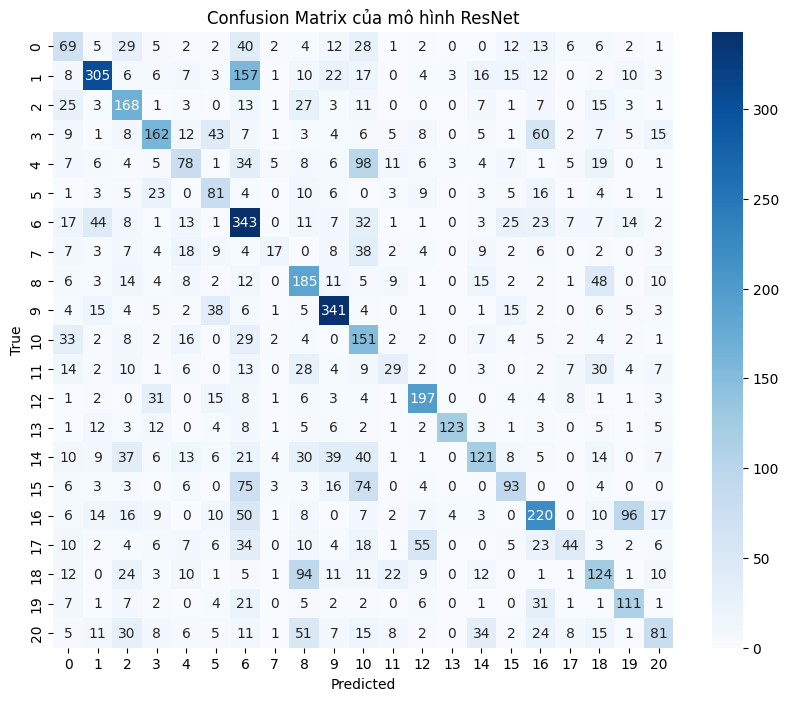


Đang vẽ biểu đồ Loss và Accuracy...


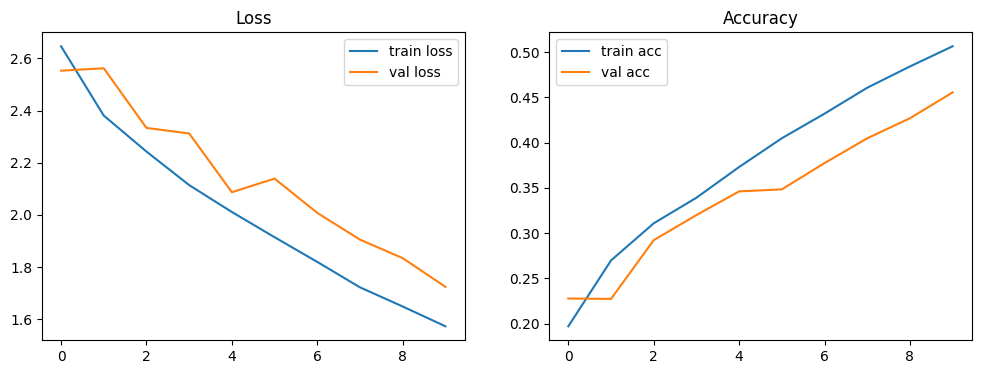

<Figure size 640x480 with 0 Axes>

In [6]:
import sys
sys.path.insert(0, '/kaggle/working/dl')
%run /kaggle/working/dl/main_resnet.py